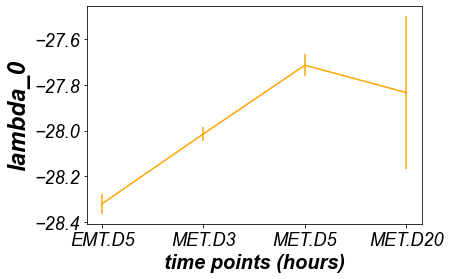

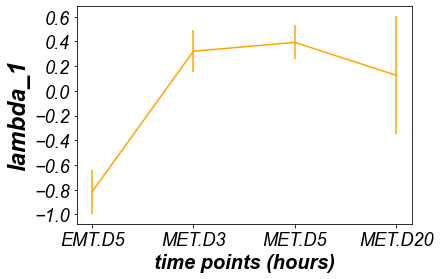

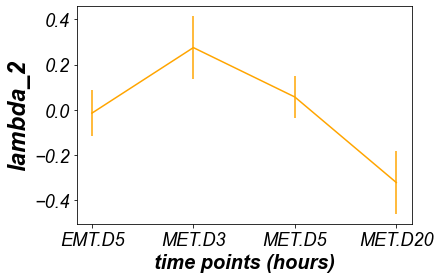

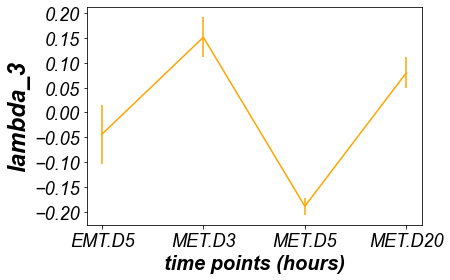

In [8]:
#!/usr/bin/env python
# coding: utf-8

# import required packages

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# function to read the entire matrix and output a dictionary
def read_full_dictionary(filename):
    time_series = []
    expression_dict = {}
    with open(filename) as file:
        for line in file:
            if "Probe_ID" in line:
                time_series = (re.split('\t|\n',line)[5:-1])
            else:
                temp = re.split('\t|\n',line)[5:-1]
                gene_name = re.split('\t|\n',line)[1]
                if gene_name in expression_dict:
                    print(gene_name," already present!")
                else:
                    temp = list(map(float, temp))
                    expression_dict[gene_name] = np.array(temp)
    return expression_dict, time_series

# function to create only a smaller dictionary with specified genes
def create_a_reduced_dictionary(expression_dict,gene_list,separator = " /// "):
    reduced_expression_dict = {}
    for i in expression_dict:
        a = i.split(separator)
        for j in a:
            if j in gene_list:
                if j in reduced_expression_dict:
                    print(j," already present (reduced dictionary creation) Not adding again !")
                    continue
                reduced_expression_dict[j] = expression_dict[i]
    return reduced_expression_dict

# convert a dictionary to a matrix
def make_matrix_from_dict(expression_dict):
    expression_mat = []
    gene_list = []
    for i in expression_dict:
        expression_mat.append(expression_dict[i])
        gene_list.append(i)
    expression_mat = np.array(expression_mat)
    return expression_mat,gene_list
    
# read a specific list of genes (fucntionally relevant stuff like tfs)
def read_list_of_specific_genes(path_to_specific_genes):
    gene_list = []
    with open(path_to_specific_genes) as f:
        for line in f:
            gene_list = re.split('\t|\n',line)
            #temp = re.split('\t|\n',line)[:-1]
            #if(temp[1]=='Mes'):
            #gene_list.append(a)
    return gene_list
    
# Use this function to return columns that are required
def get_cols(expression_mat,rep_array):
    tup = []
    for i in rep_array:
        tup.append(expression_mat[:,int(i)])
    return tuple(tup)

# set up paths to specific files
filename = "SNAI1_gene.txt"
path_to_replicates = "./replicates.txt"
path_to_tfs = "partial_EM_genes.txt"

# Read file and create a data structure to store it
def read_file_to_matrix(filename):
    time_series = []
    expression_mat = []
    with open(filename) as file:
        for line in file:
            if "Probe_ID" in line:
                time_series = (re.split('\t|\n',line)[5:-1])
                #print(time_series)
            else:
                temp = re.split('\t|\n',line)[5:-1]
                temp = list(map(float, temp))
                expression_mat.append(temp)
    expression_mat = np.array(expression_mat) 
    return expression_mat, time_series

# Make matrix for surprisal analysis
def make_matrix(cols):
    for i in range(len(cols)):
        temp = cols[i][:,np.newaxis]
        if i == 0:
            Y = temp
        else:
            Y = np.hstack((Y,temp))
    return Y

# Function for surprisal analysis
def surprisal_analysis(Y):
    Y = np.log(Y)
    Yt = Y.transpose()
    
    a = np.matmul(Yt,Y)
    evalues, evectors = np.linalg.eig(a)
    w = np.sqrt(evalues)
    
    # find eigenvectors
    
    lambda_arrays = []
    
    for i,j in enumerate(w):
        lambda_arrays.append(j*evectors[:,i])
    
    # find constrains
    
    G_array = []
    
    for i,j in enumerate(w):
        temp = np.array(lambda_arrays[i])
        G_array.append(np.dot(Y,temp)/(j**2))
    
    return w, lambda_arrays, G_array


# Reproduce data
def reproduce_data(w,lambda_arrays,G_array,num_order_reproduce,time_point):
    rep = 0
    for i in range(num_order_reproduce):
        rep += lambda_arrays[i][time_point]*G_array[i]    
    return rep

# Consistency check
def consistency_check(G_array):
    for i in range(len(G_array)):
        print("Consistency Check: ",i,"\t",np.dot(np.transpose(G_array[i]),G_array[i]))

# Calculate free energy
def free_energy(lambda_arrays,G_array,gene_num,phenotype):
    return(lambda_arrays[phenotype]*G_array[phenotype][gene_num])

# Plot graph with error bars
def plot_errorbar_plots(t,data,ylab,xlab):
    mean_array = np.zeros(len(data[0]))
    std_array = np.zeros(len(data[0]))
    for i in data:
        mean_array += np.array(i)/len(data)
    for i,j in enumerate(data[0]):
        x = []
        for k in data:
            x.append(k[i])
        std_array[i] = np.std(x)
    plt.errorbar(t,mean_array,yerr=std_array,c="orange")
    plt.xlabel(xlab+" (hours)",fontname="Arial", fontsize=20, style='italic', fontweight='bold')
    plt.ylabel(ylab,fontname="Arial", fontsize=24, style='italic', fontweight='bold')
    plt.xticks(np.arange(4), ('EMT.D5', 'MET.D3', 'MET.D5', 'MET.D20'),fontname="Arial", fontsize = 18, style='italic')
    plt.yticks(fontname="Arial", fontsize =18 , style='italic')
    plt.show()

# Main function
num_order_reproduce = 2
time_point = 2

def read_gene_type_name(genelisttfs,path_to_tfs):
    pathway_names_list = []
    gene_list = []
    pathway_list = []
    with open(path_to_tfs) as f:
        for line in f:
            line = line. rstrip('\n')
            a = re.split('\t|\n',line)[0]
            temp = re.split('\t|\n',line)[:-1]
            #if(temp[1]=='Mes'):
            pathway_list.append(line)
            gene_list.append(a)
    for i in genelisttfs:
        for j in range(len(gene_list)):
            if i == gene_list[j]:
                pathway_names_list.append(pathway_list[j])
    return pathway_names_list

expression_dict, time_series = read_full_dictionary(filename)
tfs = read_list_of_specific_genes(path_to_tfs)
expression_mat_full,genelistfull = make_matrix_from_dict(expression_dict)
reduced_expression_dict = create_a_reduced_dictionary(expression_dict,tfs)
expression_mat_tfs,genelisttfs = make_matrix_from_dict(reduced_expression_dict)
#pathway_names_list = read_gene_type_name(genelisttfs,path_to_tfs)
expression_mat_full = np.power(expression_mat_full,2)
expression_mat_tfs = np.power(expression_mat_tfs,2)

def correct_evectors_sign(arr):
    init = arr[0]
    for i,j in enumerate(arr):
        arr[i] = np.sign(np.dot(np.transpose(init),arr[i])) * arr[i]
    return arr

lamb = {0:[],1:[],2:[],3:[]}
G = {0:[],1:[],2:[],3:[]}
rep_num = 0
with open(path_to_replicates) as f:
    for line in f:
        rep_num+=1
        a = line[:-1].split("\t")
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change matrix here 
        cols = get_cols(expression_mat_tfs,a)
        Y = make_matrix(cols)
        w, lambda_arrays, G_array = surprisal_analysis(Y)
        #consistency_check(G_array)
        lamb[0].append(lambda_arrays[0])
        lamb[1].append(lambda_arrays[1])
        lamb[2].append(lambda_arrays[2])
        lamb[3].append(lambda_arrays[3])
        G[0].append(G_array[0])
        G[1].append(G_array[1])
        G[2].append(G_array[2])
        G[3].append(G_array[3])
        
x = list(dict.fromkeys(time_series)) ## Remove duplicates from time_series
x = list(map(float,x))

def top_up_20_pathway_names(phenotype,rep_num):   
    top_up_20=[]
    top_up_20_idx = np.argsort(G[phenotype][rep_num])[-20:]
    top_up_20_values = [G[phenotype][rep_num][i] for i in top_up_20_idx]
    for i in top_up_20_idx:
        top_up_20.append(pathway_names_list[i])
    return top_up_20

def top_down_20_pathway_names(phenotype,rep_num): 
    top_down_20=[]
    top_down_20_idx = np.argsort(G[phenotype][rep_num])[0:20]
    top_down_20_values = [G[phenotype][rep_num][i] for i in top_down_20_idx]
    for i in top_down_20_idx:
        top_down_20.append(pathway_names_list[i])
    return top_down_20

def ordered_gene_list(phenotype,rep_num):
    f1 = open("Lambda_"+str(phenotype)+"_replicate_"+str(rep_num)+"_genelist.txt","w") 
    sorted_idx = np.argsort(G[phenotype][rep_num])
    sorted_values = [G[phenotype][rep_num][i] for i in sorted_idx]
    for i in sorted_idx:
        f1.write(str(pathway_names_list[i])+" : "+str(G[phenotype][rep_num][i])+"\n")
    f1.close()
    
top_up_20_pathways={0:{0:[],1:[],2:[]},1:{0:[],1:[],2:[]},2:{0:[],1:[],2:[]},3:{0:[],1:[],2:[]}}
top_down_20_pathways={0:{0:[],1:[],2:[]},1:{0:[],1:[],2:[]},2:{0:[],1:[],2:[]},3:{0:[],1:[],2:[]}}

total_replicates = 3
for phenotype in range(4):
    lamb[phenotype] = correct_evectors_sign(lamb[phenotype])
    G[phenotype] = correct_evectors_sign(G[phenotype])
    #for rep_num in range(total_replicates):
        # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change name here
        #with open("./replicates/tfs_replicate_"+str(rep_num)+"_phenotype_"+str(phenotype)+".txt","w") as f1:
     #       for idx,g in enumerate(G[phenotype][rep_num]):
                # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # change gene list here
      #          s = str(idx)+"\t"+str(genelisttfs[idx])+"\t"+str(g)
       #         free_energy_array = lamb[phenotype][rep_num]*G[phenotype][rep_num][idx]
        #        for timept in free_energy_array:
         #           s+="\t"+str(timept)
                #f1.write(s+"\n")
          #  top_up_20_pathways[phenotype][rep_num] = top_up_20_pathway_names(phenotype,rep_num)
           # top_down_20_pathways[phenotype][rep_num] = top_down_20_pathway_names(phenotype,rep_num)
            #print("Top upregulated 20 pathways for lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
            #print(top_up_20_pathways[phenotype][rep_num])
            #print("Top downregulated 20 pathways for lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
            #print(top_down_20_pathways[phenotype][rep_num])
            #if(phenotype == 1 or phenotype ==2):
                #ordered_gene_list(phenotype,rep_num)
    plot_errorbar_plots(x,correct_evectors_sign(lamb[phenotype]),"lambda_"+str(phenotype),"time points")
    

-14.249985463234061


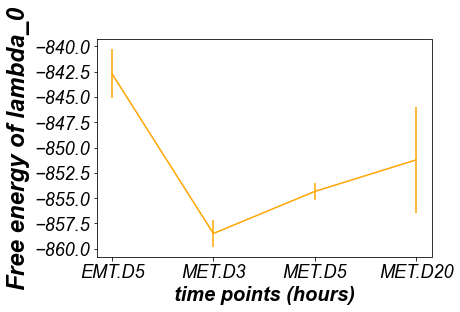

0.3536086447877098


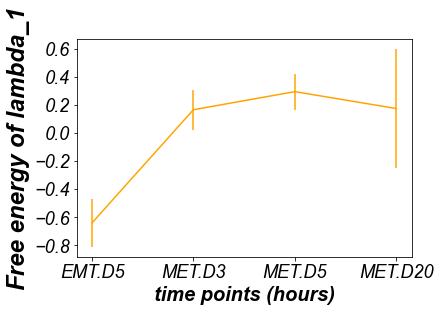

0.23501537728756053


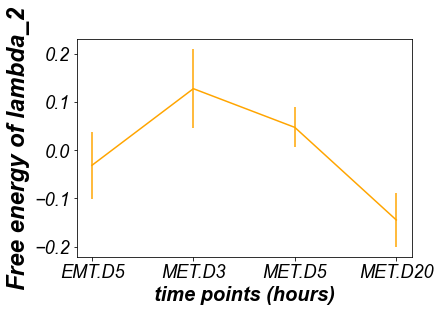

-0.014893956442917024


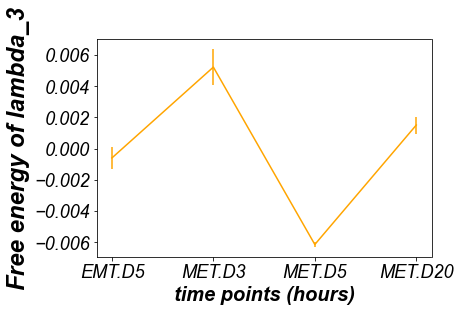

In [14]:
for phenotype in range(4):
    sum = 0.0
    for i in range(len(pathway_names_list)):        #insert total number of genes here
        sum = sum + G[phenotype][0][i]
    print(sum)
    lamb_list = correct_evectors_sign(lamb[phenotype])
    free_energy = [element * sum * (-1) for element in lamb_list]
    plot_errorbar_plots(x,free_energy,"Free energy of lambda_"+str(phenotype),"time points")
    

In [2]:
#calculating SingScores for epi and mes gene lists
import operator

#storing each sample in a separate dictionary
def create_dictionaries_for_samples(filename,sampleno):
    sample_dict = {}
    with open(filename) as f:
        for line in f:
            if 'Probe_ID' not in line:
                temp1 = re.split('\t|\n',line)[1]
                temp2 = re.split('\t|\n',line)[sampleno+4]
                sample_dict[temp1]=temp2
    return sample_dict
                    
filename = "SNAI1_gene.txt"

def read_genes_of_pathway(path_to_pathway_list,gene_type):
    gene_list = []
    with open(path_to_pathway_list) as f:
        for line in f:
            a = re.split('\t|\n',line)[0]
            temp = re.split('\t|\n',line)[:-1]
            if(temp[1]==gene_type):
                gene_list.append(a)
    return gene_list

#sorting each sample dictionary by gene expression values in ascending order,storing ranks of genes in each sample in sort_orders list
sort_orders = []
for i in range(1,13):
    sample_dict = create_dictionaries_for_samples(filename,i)
    sorted_x = sorted(sample_dict.items(), key=lambda x: x[1])
    out_dict = {}
    for idx, (key, _) in enumerate(sorted_x):
        out_dict[key] = idx + 1
    sort_orders.append(out_dict)

In [3]:
import numpy as np
import math 

path_to_pathway_list="EM_genes_tumour_line.txt"

flatten = lambda t: [item for sublist in t for item in sublist]

N_total = 19852           #total number of genes in each sample

def get_singscore(gene_list_of_pathway,sample_no):     #function to find SingScore of a pathway for a sample
    singscore = 0
    s = 0
    count_n = 0
    for g in gene_list_of_pathway:     #loop for iterating through the genes in the pathway
        if(sort_orders[sample_no].get(g,0) != 0):
            rank = sort_orders[sample_no].get(g,0)
            rank_norm = abs(rank - math.ceil (N_total/2))
            count_n = count_n+1
            s = s + rank_norm
    singscore = s/count_n
    s_min = (math.ceil(count_n/2)+1)/2
    s_max = (N_total-math.ceil(count_n/2)+1)/2
    singscore_norm = (singscore - s_min)/(s_max - s_min)
    return singscore_norm
 
genetype_expression_dict = {}
gene_type = ['Epi','Mes']
gene = []

for i in gene_type:      #loop for getting score for epithelial and mesenchymal gene lists
    gene = read_genes_of_pathway(path_to_pathway_list,i)
    array = np.empty(12,dtype='float')
    for j in range(0,12):   #loop for iterating through the samples for each gene type, 26 scores for each gene type
        array[j] = get_singscore(gene,j)
    genetype_expression_dict[i]=array

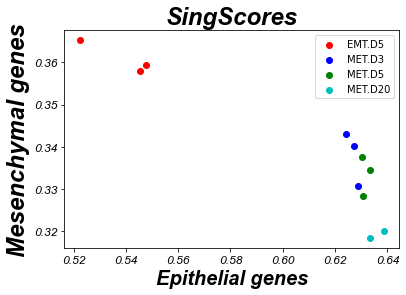

In [4]:
import itertools

#plotting singScores of epi and mes genes on a mes vs epi graph
colors = itertools.cycle(["r", "b", "g","c"])
points = [0,3,6,9]
timepoints = ['EMT.D5', 'MET.D3', 'MET.D5', 'MET.D20']
j = 0
for i in points:
    if i!=9:
        plt.scatter(genetype_expression_dict['Epi'][i:i+3],genetype_expression_dict['Mes'][i:i+3],color = next(colors),label = timepoints[j])
    else:
         plt.scatter(genetype_expression_dict['Epi'][i:i+2],genetype_expression_dict['Mes'][i:i+2],color = next(colors),label = timepoints[j])
    j = j + 1
plt.legend(loc='upper right')
plt.xlabel("Epithelial genes",fontname="Arial", fontsize=20, style='italic', fontweight='bold')
plt.ylabel("Mesenchymal genes",fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title("SingScores",fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.xticks(fontname="Arial", fontsize = 12, style='italic')
plt.yticks(fontname="Arial", fontsize = 12, style='italic')
plt.show()

In [7]:
genetype_expression_dict_SNAI2 = {'Epi': ([0.53892507, 0.53308831, 0.53819317, 0.57666248, 0.57954626,
       0.57925807, 0.57626828, 0.57792885, 0.57531612, 0.59230017,
       0.57177344, 0.59440699]), 'Mes': ([0.40319063, 0.39437659, 0.40303592, 0.37721264, 0.37521433,
       0.39455708, 0.36572775, 0.360949  , 0.38248989, 0.37424526,
       0.37600506, 0.37866517])}

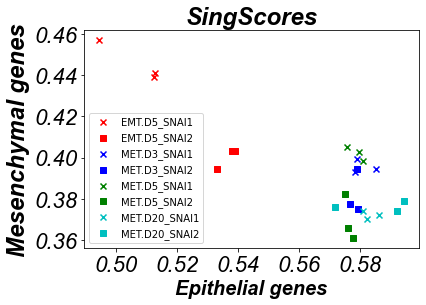

In [14]:
##plotting SingScores of SNAI1 and SNAI2 together on same plot

import itertools

#plotting singScores of epi and mes genes on a mes vs epi graph
colors = ["r", "b", "g","c"]
points = [0,3,6,9]
timepoints = ['EMT.D5_SNAI1', 'MET.D3_SNAI1', 'MET.D5_SNAI1', 'MET.D20_SNAI1']
timepoints_SNAI2 = ['EMT.D5_SNAI2', 'MET.D3_SNAI2', 'MET.D5_SNAI2', 'MET.D20_SNAI2']
j = 0
for i in points:
    plt.scatter(genetype_expression_dict['Epi'][i:i+3],genetype_expression_dict['Mes'][i:i+3],color = colors[j],marker = 'x',label = timepoints[j])
    plt.scatter(genetype_expression_dict_SNAI2['Epi'][i:i+3],genetype_expression_dict_SNAI2['Mes'][i:i+3],color = colors[j],marker = 's',label = timepoints_SNAI2[j])
    j = j + 1
plt.legend()
plt.xlabel("Epithelial genes",fontname="Arial", fontsize=20, style='italic', fontweight='bold')
plt.ylabel("Mesenchymal genes",fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title("SingScores",fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.xticks(fontname="Arial", fontsize = 22, style='italic')
plt.yticks(fontname="Arial", fontsize = 22, style='italic')
plt.show()

In [15]:
print(len(pathway_names_list))

207


In [12]:
##finding no. of upregulated, downregulated genes etc. in partial EM gene list
phenotype = 3
gene_tot = len(reduced_expression_dict) #no. of genes in reduced_expression_dict
for rep_num in range(3):
    Gup_no = 0
    Gdown_no = 0
    for i in range(gene_tot):
        if G[phenotype][rep_num][i] >= 0:
            Gup_no = Gup_no + 1
        Gdown_no = gene_tot - Gup_no
    print("Percentage of genes in partial EM gene list which are upregulated in lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
    print((Gup_no/gene_tot)*100)
    print("Percentage of genes in partial EM gene list which are downregulated in lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
    print((Gdown_no/gene_tot)*100)

Percentage of genes in partial EM gene list which are upregulated in lambda_3 replicate_0:
48.97959183673469
Percentage of genes in partial EM gene list which are downregulated in lambda_3 replicate_0:
51.02040816326531
Percentage of genes in partial EM gene list which are upregulated in lambda_3 replicate_1:
53.06122448979592
Percentage of genes in partial EM gene list which are downregulated in lambda_3 replicate_1:
46.93877551020408
Percentage of genes in partial EM gene list which are upregulated in lambda_3 replicate_2:
42.857142857142854
Percentage of genes in partial EM gene list which are downregulated in lambda_3 replicate_2:
57.14285714285714


In [7]:
#finding conditional probabilities of a gene being upregulated provided it is epithelial and vice versa
phenotype = 2
gene_tot = len(reduced_expression_dict) #no. of genes in reduced_expression_dict
epi_no = 0
for i in range(gene_tot):
    if re.split('\t',pathway_names_list[i])[1] == 'Epi':
        epi_no = epi_no + 1
mes_no = gene_tot - epi_no
for rep_num in range(3):
    Gup_no = 0
    Gdown_no = 0
    Gupmes_no = 0
    Gdownepi_no = 0
    for i in range(gene_tot):
        if G[phenotype][rep_num][i] >= 0:
            Gup_no = Gup_no + 1
        Gdown_no = gene_tot - Gup_no
        if G[phenotype][rep_num][i] >= 0 and re.split('\t',pathway_names_list[i])[1] == 'Mes':
            Gupmes_no = Gupmes_no + 1
        if G[phenotype][rep_num][i] < 0 and re.split('\t',pathway_names_list[i])[1] == 'Epi':
            Gdownepi_no = Gdownepi_no + 1
    Pup_given_mes = Gupmes_no / mes_no
    Pmes_given_up = Gupmes_no / Gup_no
    Pdown_given_epi = Gdownepi_no / epi_no
    Pepi_given_down = Gdownepi_no / Gdown_no
    print("Probability of a gene being upregulated given it is mesenchymal in lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
    print(Pup_given_mes)
    print("Probability of a gene being mesenchymal given it is upregulated in lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
    print(Pmes_given_up)
    print("Probability of a gene being downregulated given it is epithelial in lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
    print(Pdown_given_epi)
    print("Probability of a gene being epithelial given it is downregulated in lambda_"+str(phenotype)+" replicate_"+str(rep_num)+":")
    print(Pepi_given_down)
    

Probability of a gene being upregulated given it is mesenchymal in lambda_2 replicate_0:
0.6141304347826086
Probability of a gene being mesenchymal given it is upregulated in lambda_2 replicate_0:
0.6312849162011173
Probability of a gene being downregulated given it is epithelial in lambda_2 replicate_0:
0.4358974358974359
Probability of a gene being epithelial given it is downregulated in lambda_2 replicate_0:
0.4180327868852459
Probability of a gene being upregulated given it is mesenchymal in lambda_2 replicate_1:
0.5869565217391305
Probability of a gene being mesenchymal given it is upregulated in lambda_2 replicate_1:
0.6206896551724138
Probability of a gene being downregulated given it is epithelial in lambda_2 replicate_1:
0.4358974358974359
Probability of a gene being epithelial given it is downregulated in lambda_2 replicate_1:
0.4015748031496063
Probability of a gene being upregulated given it is mesenchymal in lambda_2 replicate_2:
0.483695652173913
Probability of a gene bei

In [12]:
#print(top_up_20_pathways)
from math import*
 
def jaccard_similarity(x,y,z):
 
 intersection_cardinality = len(set.intersection(*[set(x), set(y), set(z)]))
 union_cardinality = len(set.union(*[set(x), set(y), set(z)]))
 return intersection_cardinality/float(union_cardinality)

for i in range(0,4):
    print("Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_"+str(i))
    print (jaccard_similarity(top_up_20_pathways[i][0][0],top_up_20_pathways[i][1][0],top_up_20_pathways[i][2][0]))
    print("Jaccard index of similarity between replicates in top 20 downregulated pathways contributing to lambda_"+str(i))
    print (jaccard_similarity(top_down_20_pathways[i][0][0],top_down_20_pathways[i][1][0],top_down_20_pathways[i][2][0]))

Jaccard index of similarity between replicates in top 20 upregulated pathways contributing to lambda_0


IndexError: list index out of range